# Modelling continuous data with Tensoflow Probability

**Goal:** In this notebook you will learn how work with TFP. You will set up linear regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant, montonic and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will always depend linearly on the input. You compare the performace of the 3 models based on the NLL on a validaiton set and use the one with the lowest NLL to predict the test set. Finally, you will also do an extrapolation experiment with the best model and look how the predicted CPD behaves.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. In addition you will find three exercises where you can do some experiments by yourself.

**Dataset:** 
You work with a simulated dataset that looks a bit like a fish when visualized in a scatterplot. The data is simulated to have  a linear slope but non-constant variance. The variance starts with a large value then slowly decreases to increase again and in the end it decreases again. You split the data into train, validation and test dataset.

**Content:**
* Work with a Normal distribution in TFP
* Simulate and split the dataset 
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and monotoic standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and flexible standart deviation $\sigma$ (by adding hidden layers)
* Compare the different models based on the NLL loss on the validation dataset
* Choose one of these model to predict the test dataset and calculate the NLL on the test data
* Make a extrapolation experiment with the best model and look how the predicted CPD behaves

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_01.ipynb)



In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


In [3]:
!pip install tensorflow_probability==0.8.0

#### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


### Working with a TFP Normal distribution

Here you can see how to work with normal distribution in TFP.

In [5]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=3, scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor([3.4912028 1.7360613], shape=(2,), dtype=float32)
tf.Tensor([0.2520768  0.18648346], shape=(2,), dtype=float32)


### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  

### Simulate the fishlike data

In the next few cells you will simulate some (x,y)-data where the y increases on average linerly with x but has non-constant variance that so that scatterplot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. 

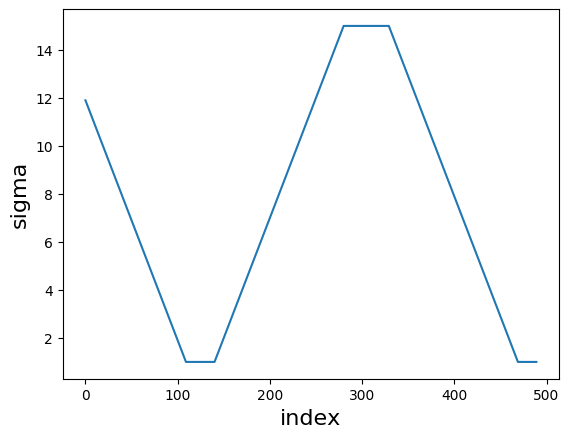

In [6]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


Now you will sample uniformly distributed x values in the range from -1 to 6. You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons). 

In [0]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data complete. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [0]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

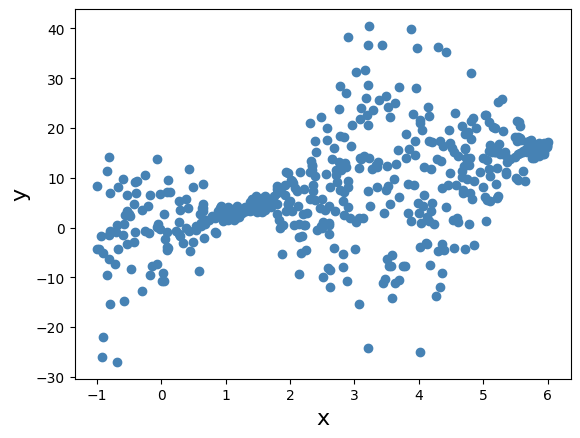

In [10]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [0]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


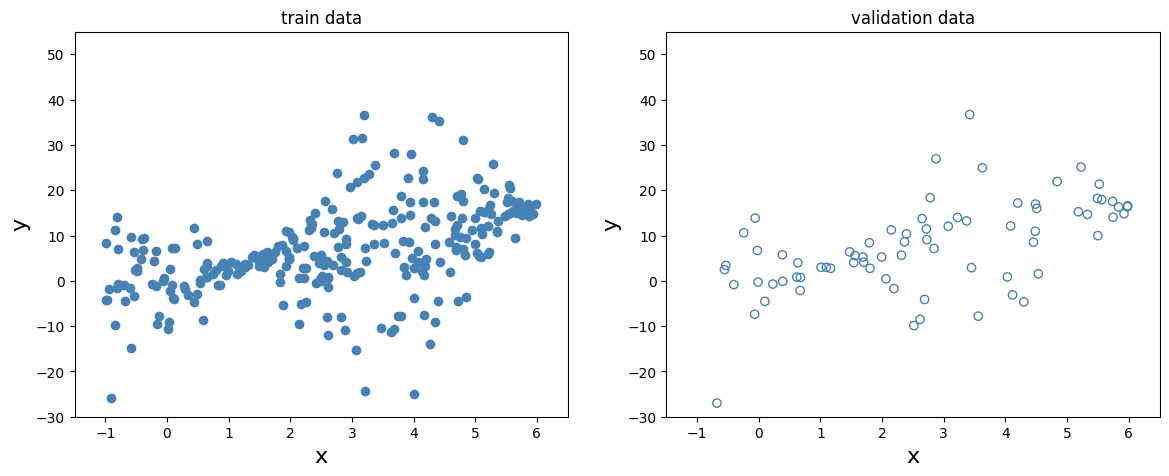

In [13]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.savefig("5.fish.split.pdf")

## Fit a linear regression model with constant variance

In the next cells you will define and fit a linear model on the simulated fish data with keras and the tensorflow probability framework. You define a simple linear regression NN with only two parameters to model the output as a gaussian conditional probability distribution with constant $\sigma$ = 1 (scale). You use the NLL as loss function. In the TFP framework it is very easy to define the NLL as loss function (see A).


In [14]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)# set the sd to the fixed value 1

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_1 = Model(inputs=inputs, outputs=dist)
model_sd_1.compile(Adam(), loss=NLL) #E

#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Compiling the model with NLL as loss function

model_sd_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_1.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

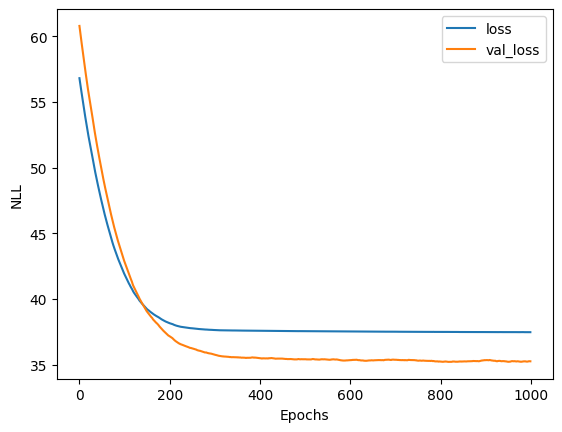

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In the next cell you define a model that predicts only the mean of the output distribution.

In [0]:
model_mean_sd_1 = Model(inputs=inputs, outputs=dist.mean())

You see a nice decrease of the training and validation loss and after some time the loss converges. Let's evaluate the model by computeing the final train and validation loss.

In [18]:
print(model_sd_1.evaluate(x_train,y_train))
print(model_sd_1.evaluate(x_val,y_val))

293/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Now you will plot the trained model with the resulting mean and +-2  sigma at each x value and see how well it fits the data. Remember in this first model you used a linear model for the mean of the CPD and just fixed the standart deviation sigma to a constant value of 1 (note that you simulated the variace to be non-constant!).

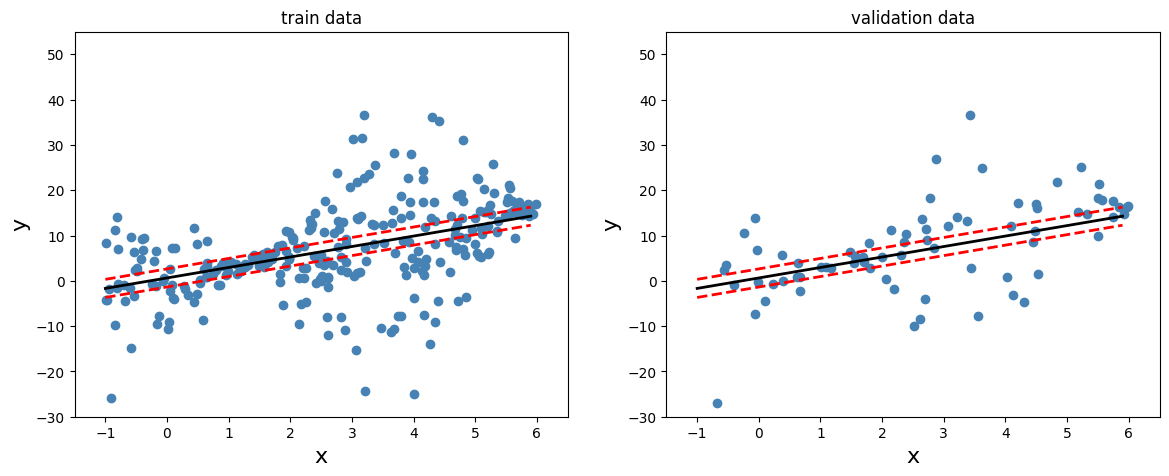

In [19]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_1.predict(x_pred)
sigma = 1
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

### Does the NLL depend on sigma, What happens with mu?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the constant standart deviation sigma in the network form 1 to 5, retrain the network and calculate the NLL for the training and validation data with the model.evaluate() function. What do you observe, is the NLL independent of sigma? What do you observe for the mean values with constant simga 1 and 5?
What would be the optimal constant sigma that leads to the lowest NLL?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

You can use the same network as before just change the scale parameter in the Normal distribution .

In [21]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params, scale=5)# set the sd to the fixed value 5

inputs = Input(shape=(1,))
params = Dense(1)(inputs)

dist = tfp.layers.DistributionLambda(my_dist)(params) 
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(), loss=NLL) 

model_sd_5.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_5.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_mean_sd_5 = Model(inputs=inputs, outputs=dist.mean())

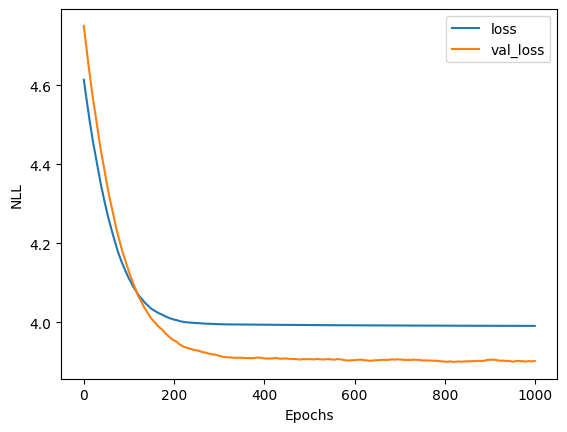

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

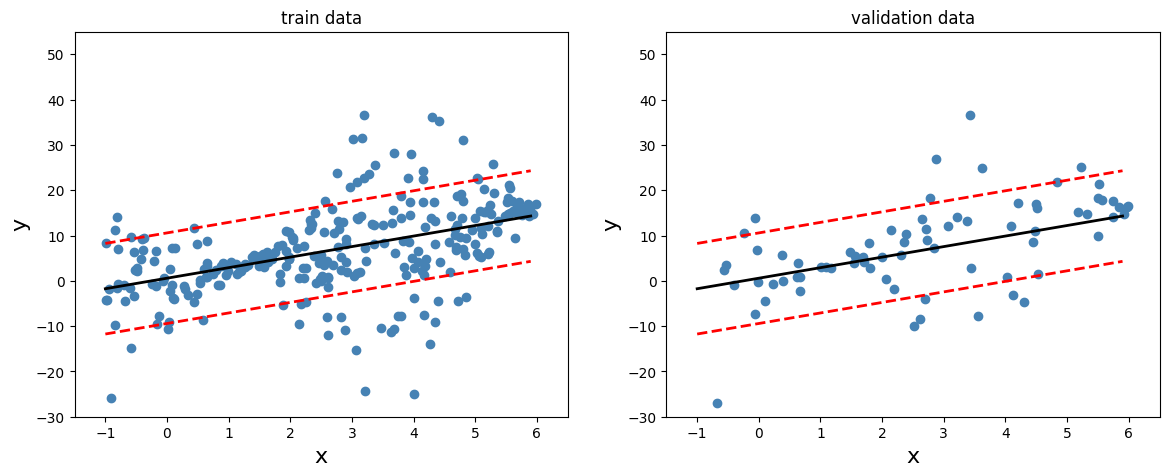

In [25]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)


plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = 5
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


In [26]:
print(model_sd_5.evaluate(x_train,y_train))
print(model_sd_5.evaluate(x_val,y_val))

293/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**If you compare the NLL on the validation data, you see that the NLL for the model with sigma=5 has a much lower NLL ~3.9 than the model with sigma=1 ~35. So the NLL is highly dependent on sigma! If you look at the prediction plots with +- 2 sigma you can see that there are a lot more points inside that band when you have a constant sigma of 5, then when you have constant sigma of 1. This means that most of this this points inside the +-2 sigma band are more likely to be observed, that's why the NLL for the fixed sigma=5 is much lower.**

In [27]:
# comapre the predicted mean for the first 5 values with fixed simga=1 and sigma=5
(model_mean_sd_1.predict(x_val)-model_mean_sd_5.predict(x_val))[0:5]

array([[0.06699753],
       [0.06518054],
       [0.06484878],
       [0.06293637],
       [0.06058085]], dtype=float32)

**Let's compare the the predicted means for all validation poits. As you can see the differences for the mean values of the model with constant sigma=1 and sigma=5 are close to 0. So the predicted mean value of the conditional probability distribution does not depend on sigma.**

You saw that the NLL depends on the standart deviation sigma and that the loss is lower if you assume a fixed sigma of 5 compared to a fixed sigma 1, but what would be the optimal sigma that minimizes the NLL? To get the optimal sigma you compute a slightly adjusted standart deviation of the residuals.

In [28]:
preds_train = model_mean_sd_5.predict(x_train)
preds_val = model_mean_sd_5.predict(x_val)

SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(x_train)-2))
sigma_

8.579472720705217

**To calculate the NLL with the optimal constant sigma, you can use the formula for the $$NLL = \frac{1}{n}\sum_{i=1}^{n}- log(\frac{1}{\sqrt{2 \pi \sigma^2_x}})+\frac{(y_i - \mu_i)^2}{2 \sigma^2_x}$$ or use the probability density function of the Normal distribution form the scipy.stats library.
You see that indeed the NLL with ~ 3.5 calculated with the estimated constant sigma ~ 8.5 is smaller than the NLL with the constant sigma of 5 (~3.9).**

In [29]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_mean_sd_5.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_mean_sd_5.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

3.564898021069603
3.534665724730369


In [30]:
import scipy.stats
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_train), sigma_).pdf(y_train))))
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_val), sigma_).pdf(y_val))))

3.564898021069603
3.534665724730369


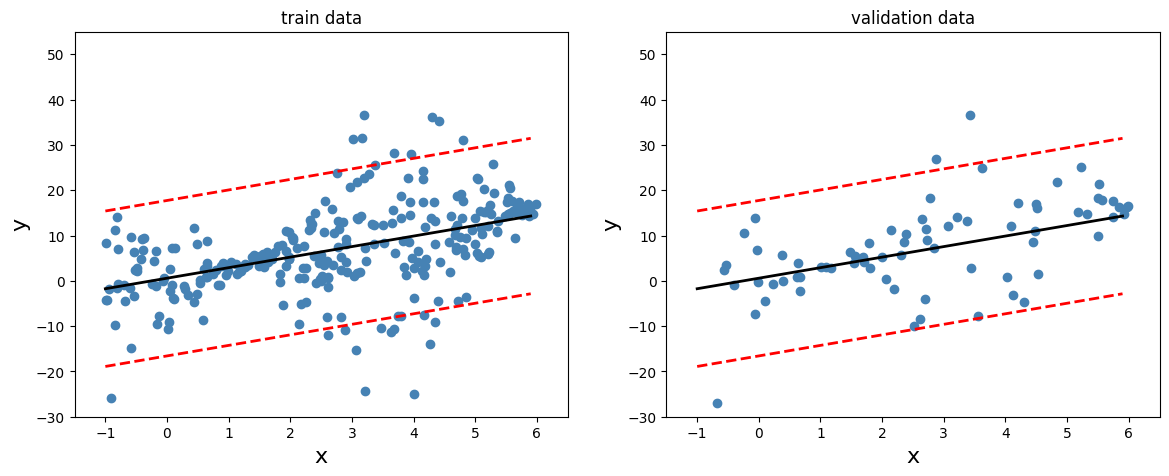

In [31]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = sigma_
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  
Return to the book to learn how to fit a model with a monotinic stadart deviation for the output distribution.

## Fit a linear regression model and allow the sd to depend in a monotonic way on the input

You probability already know that it's is not the best idea to model the standart deviation $\sigma$ with a constant value since it increases and decreases over the x values. Recall how the data was simulated. So let's try to model the standart deviation sigma in a monotonic way and compare the NLL on the validation set with our best model so far, which was the one with the optimal estimated constant sigma that had a NLL of ~3.5.  To define a monotonic standart deviation, you can use again a Normal distribution in TFP, but this time you don't fix sigma, but you fit both parameters the mean and sigma. You don't use any hidden layers in between (from the book you already know about the softplus transformation for the sigma node). As the loss function you again use the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
params = Dense(2)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL) 

In [33]:
model_monotoic_sd.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=6000, verbose=0, validation_data=(x_val,y_val))

In the next cell you define two models to predict the mean $\mu$ and the standart deviation $\sigma$ of the output distribution.

In [0]:
model_monotoic_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_monotoic_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

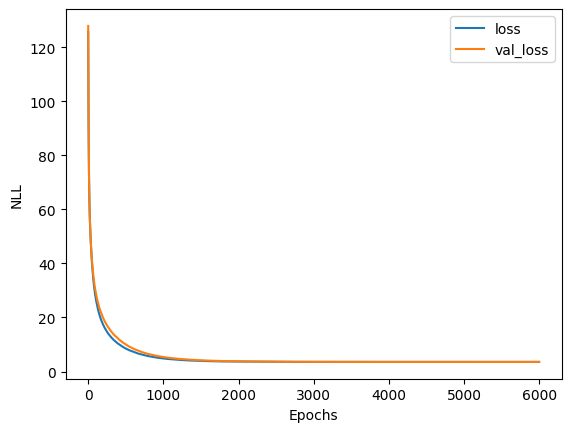

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()


In [37]:
print(model_monotoic_sd.evaluate(x_train,y_train))
print(model_monotoic_sd.evaluate(x_val,y_val))

293/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

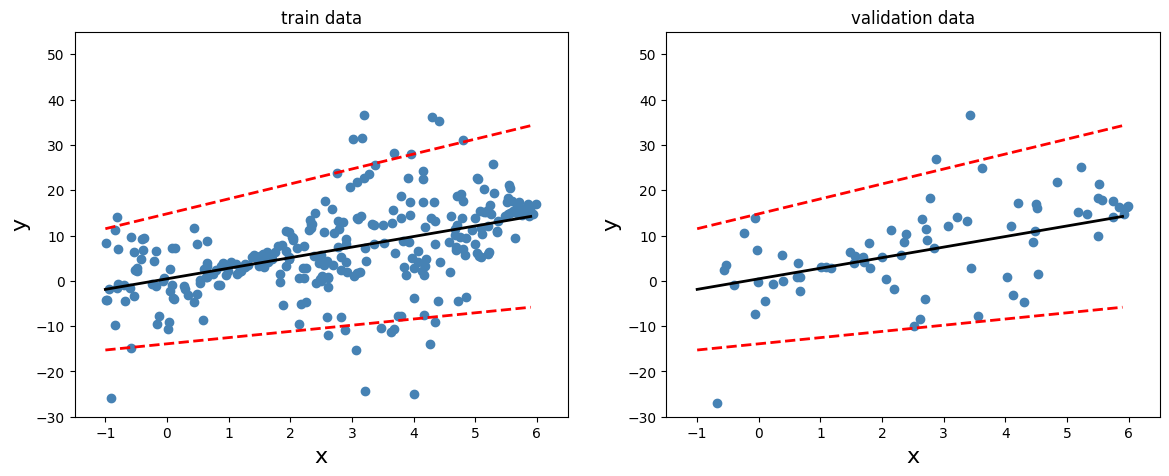

In [38]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the data.You see that the standart deviation is no longer constant but increases with bigger x-values - this is still not describing the data variance very well. The mean of the distribution is still linear because there are no hidden layers in this model. Even if this model is more complex than the ones before, the NLL on the validation set with ~3.5 is unfortunately still a bit higher compared to the model with the estimated constant sigma, which had a NLL of ~3.5. The main reason for this is because the simulated variance is not monotonic.

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

From the model with the monotonic standart deviation you probability guessed that you need a model where the standart deviation sigma is non-linear and able to increase for some x-values but then agian decrease for others. Remeber how the data was simulated. Let's try that and see if we can decrease the NLL below ~3.5. You will now, define and fit a model that models the mean of the normal distribution linearly (no hidden layer for the mean parameter) but for the standart devation sigma, you will use 2 hidden layers in beetween (with 30 and 20 nodes). Because of the two hidden layers the resulting stadart deviation is now able to change non-linarly with x, if necessary. You will use again TFP and keras for the model defintion. The loss function you use again the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs)
hidden1 = Dense(30,activation="relu")(inputs)
hidden2 = Dense(20,activation="relu")(hidden1)
out2 = Dense(1)(hidden2)
params = Concatenate()([out1,out2])
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)


In [40]:
model_flex_sd.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           60          input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 20)           620         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            2           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
history = model_flex_sd.fit(x_train, y_train, epochs=6000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

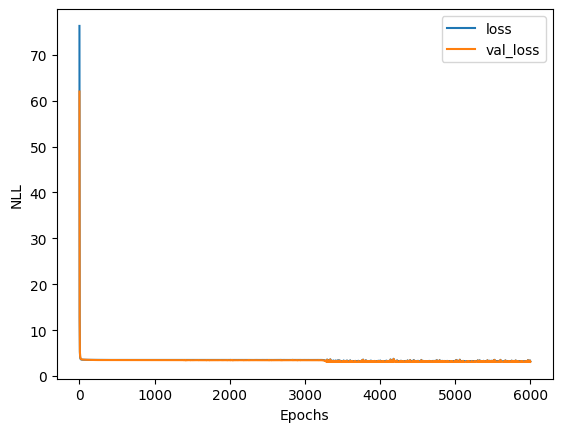

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()


In [44]:
print(model_flex_sd.evaluate(x_train,y_train))
print(model_flex_sd.evaluate(x_val,y_val))

293/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

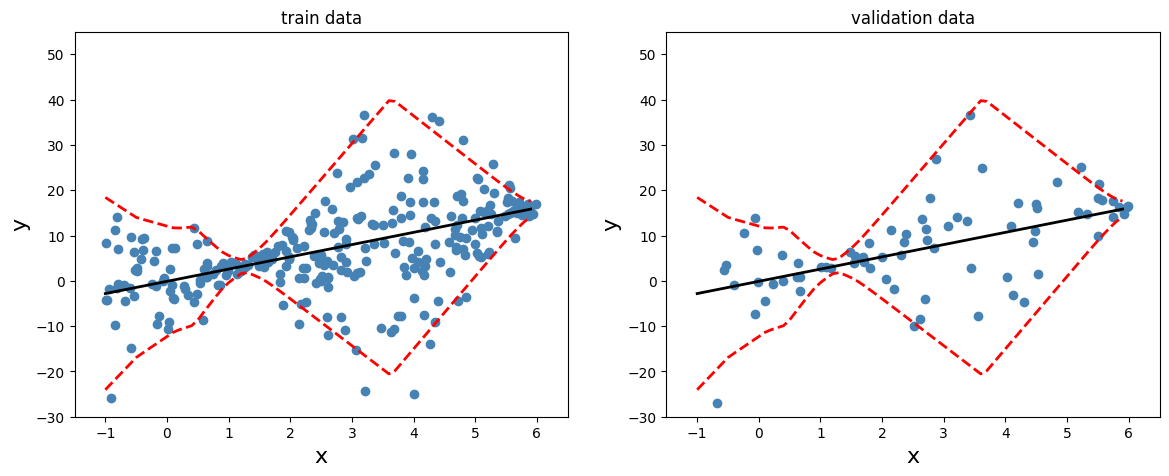

In [45]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the data. It looks really nice, just like a fish and exacly how we simulated the data. You see that the standart deviation is not constant but depends in a non-linearl fashion on x. The mean still still depends linearly on x, constrained by the model, which has no hidden layer between x and the mean-output node. If you look at the NLL on the validation dataset you see that it really is lower than ~3.5, it now is only ~3.1. So with this more complex model you get the lowest NLL on the  the validation set!

### Prediction of the test with the best model

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 2: Which of the three fitted models shows the best prediction performance on new unseed data? Use the three fitted models to predict the test set and calculate the corresponding test NLL. What value do you expect for the test NLL? Does the observed test NLL meet your expectation?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

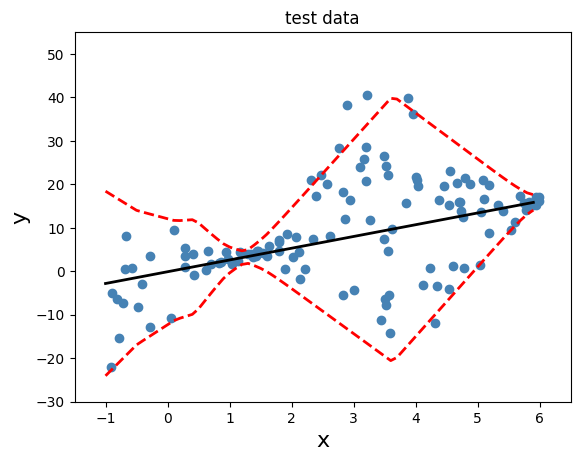

In [47]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_pred = np.arange(-1,6,0.1)
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [48]:
model_flex_sd.evaluate(x_test,y_test)

123/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

3.183431503249378

In [49]:
np.mean(-model_flex_sd(x_test).log_prob(y_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



3.1834314

In [50]:
NLL_test=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(model_flex_sd_sd.predict(x_test)))))+
                 ((np.square(y_test-model_flex_sd_mean.predict(x_test))/(2*np.square(model_flex_sd_sd.predict(x_test))))))
print(NLL_test)

3.183431464249718


**The best model for new unseen data is the one with the lowest NLL on the validation dataset. So you use the model with the linear mean and the non-linear stadart deviation to predict the test dataset. The expected NLL should be around 3.1, which is the NLL that you observed for the validation dataset, and as you can see, it turns out that the NLL for the  test dataset is around that.**

### Prediction outside the training x range

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Optinal Exercise 3: Do a little extrapolateion experiment: Use the model that was trained on data with x-values between -1 and 6 to predicht the mean and sigma of the outcome y for a x-values in the range from -5 to 10. What do you observe?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

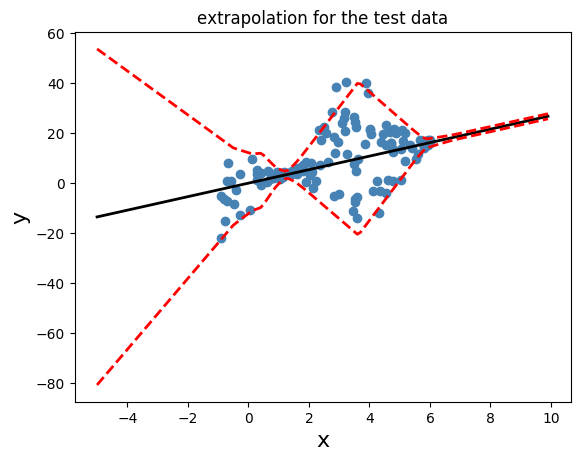

In [52]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_new=np.arange(-5,10,0.1)
preds_new = model_flex_sd_mean.predict(x_new)
plt.plot(x_new,preds_new,color="black",linewidth=2)
plt.plot(x_new,preds_new+2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2) 
plt.plot(x_new,preds_new-2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("extrapolation for the test data")
plt.show()

**You can see that in the extaploation range the model predicts quite strange CPDs. For x values larger than 6 it predicts almost zero variance, which suggests high certainty in a range where we have never seen any datapoints. For x values below -1 it predicts CPDs with linearly increasing standart deviation.**